In [1]:
from gym_minigrid.wrappers import *
from env import *
from memory import ReplayBuffer, RemergeMemory
from agent import DQN

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from itertools import count

device = torch.device("cuda:4")

class RandomAgent:
    def __init__(self, action_dim):
        self.action_dim = action_dim
    
    def step(self, observation=None):
        return np.random.randint(self.action_dim)

# [1,2,
#  3,4]
# 0-up, 1-right, 2-down, 3-left

### agent related stuff

In [2]:
from main import train, test

In [3]:
task = FourRoomsTask(task_type='fixed', 
                     agent_ini_pos=(2,2),
                     goal_pos=(2,4),
                     reward_type='sparse', 
                     goalcond=True, 
                     seed=32)
obs = task.reset()
memory = ReplayBuffer()
agent = DQN(state_dim=obs['image'].shape, action_dim=4, goalcond=True, 
            device=device, memory=memory)

In [392]:
task = FourRoomsTask(task_type='preset', 
                     agent_ini_pos=(12,12),
                     goal_pos=(9,13),
                     reward_type='sparse', 
                     goalcond=True, 
                     seed=32)
# task.set_phase('test')
obs = task.reset()

In [14]:
task = task.clone()
obs = task.reset()

In [51]:
# 0-left, 1-down, 2-right, 3-up
obs, r, done, _ = task.step(2)
print(r, done)

-1.0 False


Text(0.5, 1.0, 'goal')

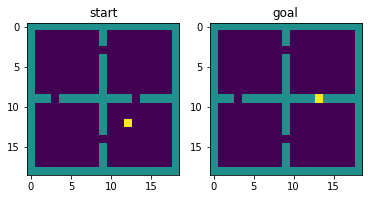

In [391]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(obs['image'][0])
axes[1].imshow(obs['goal'][0])
axes[0].set_title('start')
axes[1].set_title('goal')

In [393]:
task.step(0)

({'image': array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
          [1, 0, 0, 0, 0,

In [87]:
0.05 + (0.9 - 0.05) * \
    math.exp(-1. * 700 / 250)

0.10168855323143527

In [369]:
2*19*19

722

In [384]:
batch = memory.sample(batch_size=3)

state_batch = torch.cat(batch.state)
goal_batch = torch.cat(batch.goal)

In [386]:
state_batch.view(state_batch.size(0), -1).shape

torch.Size([3, 361])

In [387]:
torch.cat((state_batch.view(state_batch.size(0), -1), state_batch.view(goal_batch.size(0), -1)), dim=-1).shape

torch.Size([3, 722])

#### memory related stuff

In [2]:
from collections import deque, namedtuple

In [214]:
task = FourRoomsTask(task_type='ti-2', 
                     reward_type='sparse2', 
                     goalcond=True, 
                     seed=32)
ra = RandomAgent(4)

In [215]:
obs = task.reset()

Text(0.5, 1.0, 'goal')

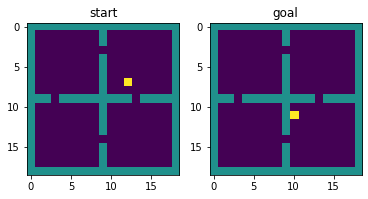

In [216]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(obs['image'][0])
axes[1].imshow(obs['goal'][0])
axes[0].set_title('start')
axes[1].set_title('goal')

In [354]:
memory = ReplayBuffer(num_slot=6)

In [355]:
# collect some random transitions for prototyping

obs = task.reset()
state = torch.from_numpy(obs['image'].astype(np.float32)).unsqueeze(0)
goal = torch.from_numpy(obs['goal'].astype(np.float32)).unsqueeze(0)

for _ in range(6):
    
    action = ra.step(state)
    next_obs, reward, done, _ = task.step(action)
    next_state = torch.from_numpy(next_obs['image'].astype(np.float32)).unsqueeze(0)
    # goal shouldn't change within an episode
    reward = torch.tensor([reward], dtype=torch.float)

    if done:
        next_state = None

    memory.add(state, action, reward, next_state, goal)
    if done:
        obs = task.reset()
        state = torch.from_numpy(obs['image'].astype(np.float32)).unsqueeze(0)
        goal = torch.from_numpy(obs['goal'].astype(np.float32)).unsqueeze(0)
    else:
        state = next_state

In [356]:
len(memory)

6

In [724]:
class AttractorNetwork:
    
    '''
    instance-based memory with recurrent computations
    onehot memory code can be used as key to another memory storage
    '''
    
    def __init__(self, 
                 hidden_size, 
                 state_size,
                 raw_excite_weight=1.0,
                 raw_inhibit_weight=0.0,
                 weight_scale=1.0,
                 i_tau=0.1, 
                 h_tau=0.04, 
                 h_C=0., 
                 lmda=0.5, 
                 ext=0.2):
        
        self.hidden_size = hidden_size
        self.state_size = state_size
        
        self.weight_scale = weight_scale # class hyperparam?
        self.excite = raw_excite_weight * self.weight_scale
        self.inhibit = raw_inhibit_weight * self.weight_scale
        
        self.i_tau = i_tau
        self.h_tau = h_tau
        self.h_C = h_C
        self.lmda = lmda
        self.ext = ext
        
        self.weights = {
            's2h':np.zeros((self.state_size, self.hidden_size)),
            'h2s':np.zeros((self.hidden_size, self.state_size)),
            'ns2h':np.zeros((self.state_size, self.hidden_size)),
            'h2ns':np.zeros((self.hidden_size, self.state_size)),
        }
        
        self.netin_buffer = {
            's':np.zeros((1, self.state_size)),
            'ns':np.zeros((1, self.state_size)),
            'h':np.zeros((1, self.hidden_size))
        }
    
    def update_weights(self, weight_dict_key, pre_index, post_index, mode='add'):
        # add or remove a specific weight between state and link
        # pre_index indicates the node whose outgoing weights are being updated
        # post_index indicates the node whose incoming weights are being updated
        new_weights = self.weights[weight_dict_key][pre_index]

        if mode == 'add':
            new_weights[post_index] = self.excite
            # update zero weights to inhibitory
            new_weights[new_weights==0.0] = self.inhibit

        elif mode == 'del':
            new_weights[post_index] = inhibit
            # if no more excitatory connections change all weights to zero
            if sum(new_weights==excite) == 0:
                new_weights = np.zeros(len(new_weights))

        self.weights[weight_dict_key][pre_index] = new_weights

    def i_activation(self, netin):
        # logistic
        # return np.array([1/(1+np.exp(-x/self.i_tau)) for x in netin])
        # softmax
        denom = np.sum([np.exp(x/self.i_tau) for x in netin])
        return np.array([np.exp(x/self.i_tau)/denom for x in netin])

    def h_activation(self, netin):
        # hedge softmax
        denom = self.h_C**(1/self.h_tau) + np.sum([np.exp(x/self.h_tau) for x in netin])
        return np.array([np.exp(x/self.h_tau)/denom for x in netin])

    def forward(self, s_in=None, ns_in=None):
        
        s_in = s_in if s_in is not None else np.zeros((1,self.state_size))
        ns_in = ns_in if ns_in is not None else np.zeros((1,self.state_size))

        snetin = np.dot(self.h_activation(self.netin_buffer['h']),self.weights['h2s']) + self.ext*s_in
        snetin = self.lmda*(snetin) + (1-self.lmda)*self.netin_buffer['s']
        nsnetin = np.dot(self.h_activation(self.netin_buffer['h']),self.weights['h2ns']) + self.ext*ns_in
        nsnetin = self.lmda*(nsnetin) + (1-self.lmda)*self.netin_buffer['ns']
        hnetin = np.dot(self.i_activation(snetin),self.weights['s2h']) + np.dot(self.i_activation(nsnetin),self.weights['ns2h'])
        hnetin = self.lmda*(hnetin) + (1-self.lmda)*self.netin_buffer['h']

        # update netin buffer
        self.netin_buffer['s'] = snetin
        self.netin_buffer['ns'] = nsnetin
        self.netin_buffer['h'] = hnetin

        # compute activation
        sact = self.i_activation(snetin)
        nsact = self.i_activation(nsnetin)
        hact = self.h_activation(hnetin)

        return sact, nsact, hact
    
    def clean_buffer(self):
        self.netin_buffer = {
            's':np.zeros((1, self.state_size)),
            'ns':np.zeros((1, self.state_size)),
            'h':np.zeros((1, self.hidden_size))
        }
    
    def clone(self):
        x = AttractorNetwork(hidden_size=self.hidden_size, 
                             state_size=self.state_size, 
                             weight_scale=self.weight_scale,
                             i_tau=self.i_tau, 
                             h_tau=self.h_tau, 
                             h_C=self.h_C, 
                             lmda=self.lmda, 
                             ext=self.ext)
        x.weights = self.weights.copy()
        return x

In [756]:
Linked = namedtuple('Linked', ('state1', 'state2', 'step'))

class RemergeMemory(ReplayBuffer):
    
    '''
    wrapper for remerge, maintains memory content storages for state and hidden layers
    '''
    
    def __init__(self,
                 num_slot=10000,
                 batch_size=32,
                 hidden_size=1000, 
                 state_size=1000,
                 **kwargs):
        
        # self.memory is inherited from super, functions as the default batch sampling buffer
        # self.remerge is the memory network that does recurrent computation on onehot memory keys
        # self.states, next_states, and links are the corresponding content storage for self.remerge
        
        super().__init__(num_slot=num_slot, batch_size=batch_size)
        
        self.hidden_size = hidden_size
        self.state_size = state_size
        
        self.attractor_network = AttractorNetwork(hidden_size, state_size, **kwargs)
        self.states = deque()
        self.next_states = deque()
        self.links = deque()
    
    def add(self, state, action, reward, next_state, goal=None):
        super().add(state, action, reward, next_state, goal=None)
        
        # the incoming states are [B, C, H, W] tensors
        # convert to [C, H, W] np arrays
        # TODO: but don't forget to convert back!
        state = state.detach().numpy()[0]
        next_state = next_state.detach().numpy()[0]
        
        step = 1 # new links are always 1-step transitions
        new_link = Linked(*(state, next_state, step))

        if self.find_link(self.links, new_link) != -1:
            # memory link exists, don't need to adjust memory network weights
            return

        # TODO: maintain num_slots in all of (links, states, next_states)
        # TODO: when memory is freed up need to update weights
        
        # assuming implementation is correct, effective length of
        # states and next_states will always be <= links, so
        # we only need to check link capacity and free things accordingly
        if len(self.links) > self.hidden_size:
            pass

        self.links.append(new_link)
        link_index = len(self.links)-1

        state_index = self.find_state(self.states, state)
        if state_index == -1:
            self.states.append(state)
            state_index = len(self.states)-1

        next_state_index = self.find_state(self.next_states, next_state)
        if next_state_index == -1:
            self.next_states.append(next_state)
            next_state_index = len(self.next_states)-1

        # construct new weights as memory comes in
        self.attractor_network.update_weights('s2h', pre_index=state_index, post_index=link_index, mode='add')
        self.attractor_network.update_weights('h2s', pre_index=link_index, post_index=state_index, mode='add')
        self.attractor_network.update_weights('ns2h', pre_index=next_state_index, post_index=link_index, mode='add')
        self.attractor_network.update_weights('h2ns', pre_index=link_index, post_index=next_state_index, mode='add')
    
    def plan(self, s_probe=None, ns_probe=None, plan_steps=4, T=200, mode='max'):
        
        # plan_steps needs to be >=1
        # probes are in memory content space (e.g. [C,H,W])
        # ns_probe is goal state
        # self.attractor_network.forward can take None inputs
        # if plan_steps==0 one of s_probe and ns_probe better be None
        # T better be > 10
        # mode=='max': select state corresponding to max activation
        # mode=='sample': select state based on softmax activation as probabilities
        
        if s_probe is None and ns_probe is None:
            print("what do you want from meee??")
            return []
        
        # turn probes into keys
        
        s_index = self.find_state(self.states, s_probe) if s_probe is not None else -1
        s_in = self.index_to_onehot(s_index, self.state_size) if s_index != -1 else None
        ns_index = self.find_state(self.next_states, ns_probe) if ns_probe is not None else -1
        ns_in = self.index_to_onehot(ns_index, self.state_size) if ns_index != -1 else None
        
        print('s_in: ', s_in)
        print('ns_in: ', ns_in)
        
        if plan_steps==0:
            # just activate the linked memories, no multiple copies needed
            n = self.attractor_network.clone()
            
            for t in range(T):
                sact, nsact, hact = n.forward(s_in=s_in, ns_in=ns_in)
            
            if ns_probe is None:
                plan_indexes = self.activation_to_indexes(nsact, mode=mode)
                plan_keys = [self.index_to_onehot(ind, self.state_size) for ind in plan_indexes]
                plan = [self.retrieve_instance(self.next_states, key) for key in plan_keys]
            else: # hopefully s_probe is None:
                plan_indexes = self.activation_to_indexes(sact, mode=mode)
                plan_keys = [self.index_to_onehot(ind, self.state_size) for ind in plan_indexes]
                plan = [self.retrieve_instance(self.states, key) for key in plan_keys]
            return plan

        # make copies of the attractor network
        sub_networks = [self.attractor_network.clone() for _ in range(plan_steps+1)]
        
        activation_buffer = {'sact': np.zeros((len(sub_networks), self.state_size)),
                             'nsact':np.zeros((len(sub_networks), self.state_size)),
                             'hact':np.zeros((len(sub_networks), self.hidden_size))}
        
        # insert probes
        print('injecting s_in and ns_in...')
        for t in range(1):
            print('\t s_in=', s_in, '\n\t ns_in=', ns_in)
            sact, nsact, hact = sub_networks[0].forward(s_in=s_in)
            activation_buffer['sact'][0] = sact
            activation_buffer['nsact'][0] = nsact
            activation_buffer['hact'][0] = hact
            sact, nsact, hact = sub_networks[-1].forward(ns_in=ns_in)
            activation_buffer['sact'][-1] = sact
            activation_buffer['nsact'][-1] = nsact
            activation_buffer['hact'][-1] = hact
        
        print(['%.2f' % x for x in activation_buffer['sact'][0]])
        print(['%.2f' % x for x in activation_buffer['hact'][0]])
        print(['%.2f' % x for x in activation_buffer['nsact'][0]])
        
        print('run recurrent computation...')
        
        # run recurrent computation and settle (?) on plan
        # TODO: check convergence?
        # keep injecting s_in and ns_in at both ends
        for t in range(T):
            
            # propogate from state to goal
            for i in range(len(sub_networks)):
                if i==0:
                    s = s_in
                    ns = None # activation_buffer['sact'][i+1]
                elif i==len(sub_networks)-1:
                    s = None # activation_buffer['nsact'][i-1]
                    ns = ns_in
                else:
                    s = activation_buffer['nsact'][i-1] # next state from last sub network
                    ns = activation_buffer['sact'][i+1] # state from next sub network
                
                sact, nsact, hact = sub_networks[i].forward(s_in=s, ns_in=ns)
                activation_buffer['sact'][i] = sact
                activation_buffer['nsact'][i] = nsact
                activation_buffer['hact'][i] = hact
            
            # propogate from goal back to state
            for i in reversed(range(len(sub_networks))):
                if i==len(sub_networks)-1:
                    s = None # activation_buffer['nsact'][i-1]
                    ns = ns_in
                elif i==0:
                    s = s_in
                    ns = None # activation_buffer['sact'][i+1]
                else:
                    s = activation_buffer['nsact'][i-1] # next state from last sub network
                    ns = activation_buffer['sact'][i+1] # state from next sub network
                    
                sact, nsact, hact = sub_networks[i].forward(s_in=s, ns_in=ns)
                activation_buffer['sact'][i] = sact
                activation_buffer['nsact'][i] = nsact
                activation_buffer['hact'][i] = hact
            
            print(['%.2f' % x for x in activation_buffer['sact'][0]])
            print(['%.2f' % x for x in activation_buffer['hact'][0]])
            print(['%.2f' % x for x in activation_buffer['nsact'][0]])
            print()
        
        # form plan
        plan_indexes = self.activation_to_indexes(activation_buffer['nsact'][:-1], mode=mode)
        print(plan_indexes)
        plan_keys = [self.index_to_onehot(ind, self.state_size) for ind in plan_indexes]
        # retrieve content from memory
        plan = [self.retrieve_instance(self.next_states, key) for key in plan_keys]

        return plan
    
    def activation_to_indexes(self, activation, mode='max'):
        # activations is shape [B, state_size]
        print(activation)
        if mode=='max':
            plan_indexes = np.argmax(activation, axis=-1)
        elif mode=='sample':
            plan_indexes = list(map(self.sample_state, activation))
        return plan_indexes
    
    def sample_state(self, probs):
        print(probs)
        # in case there is a tie
        elements = list(range(self.state_size))
        return np.random.choice(elements, 1, p=probs)[0]

    def find_link(self, links, link):
        # finds first instance of same link in links else -1
        for i, x in enumerate(links):
            checks = [np.array_equal(getattr(x, f), getattr(link, f)) for f in x._fields]
            if sum(checks) == len(checks):
                return i
        return -1

    def find_state(self, states, state):
        # finds first instance of state in states else -1
        checks = [np.array_equal(x, state) for x in states]
        if sum(checks)==0:
            return -1
        else:
            return checks.index(True)

    def retrieve_instance(self, memory, onehot_key):
        # works for both link and state storages
        if len(np.unique(onehot_key))!=2 or (sum(onehot_key) > 1):
            # okay this isn't the perfect check but...
            raise ValueError('invalid memory key!')
        return memory[self.onehot_to_index(onehot_key)]

    def onehot_to_index(self, onehot):
        return np.where(onehot==1)[0][0]

    def index_to_onehot(self, i, length):
        key = np.zeros(length)
        key[i] = 1.
        return key

In [246]:
def find_all_ns(s):
    x = []
    for l in rmm.links:
        if np.array_equal(s, l.state1):
            x.append(rmm.find_state(rmm.next_states, l.state2))
    return x

In [247]:
find_all_ns(s)

[]

In [757]:
rmm = RemergeMemory(hidden_size=6, state_size=6)
for x in memory.memory:
    rmm.add(x.state, x.action, x.reward, x.next_state, x.goal)

In [758]:
print(len(rmm.links))
print(len(rmm.states))
print(len(rmm.next_states))

6
4
4


In [759]:
for i, l in enumerate(rmm.links):
    print('link %d'%i, end=':  ')
    s = l.state1
    ns = l.state2
    print(rmm.find_state(rmm.states, s), '-->', rmm.find_state(rmm.next_states, ns))

link 0:  0 --> 0
link 1:  1 --> 1
link 2:  0 --> 1
link 3:  0 --> 2
link 4:  2 --> 3
link 5:  3 --> 0


In [760]:
s = rmm.links[0].state1
ns = rmm.links[4].state2

In [761]:
plan = rmm.plan(s_probe=s, ns_probe=ns, plan_steps=1, T=6, mode='sample')

s_in:  [1. 0. 0. 0. 0. 0.]
ns_in:  [0. 0. 0. 1. 0. 0.]
injecting s_in and ns_in...
	 s_in= [1. 0. 0. 0. 0. 0.] 
	 ns_in= [0. 0. 0. 1. 0. 0.]
['0.79', '0.05', '0.05', '0.05', '0.02', '0.02']
['0.47', '0.00', '0.47', '0.05', '0.00', '0.00']
['0.31', '0.31', '0.13', '0.13', '0.06', '0.06']
run recurrent computation...
['1.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.50', '0.00', '0.50', '0.00', '0.00', '0.00']
['0.48', '0.48', '0.01', '0.01', '0.01', '0.01']

['1.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.50', '0.00', '0.50', '0.00', '0.00', '0.00']
['0.49', '0.49', '0.00', '0.00', '0.00', '0.00']

['1.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.50', '0.00', '0.50', '0.00', '0.00', '0.00']
['0.49', '0.49', '0.00', '0.00', '0.00', '0.00']

['1.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.50', '0.00', '0.50', '0.00', '0.00', '0.00']
['0.49', '0.49', '0.00', '0.00', '0.00', '0.00']

['1.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.50', '0.00', '0.50', '0.00', '0.00', '

In [196]:
plan[0].shape

(1, 19, 19)

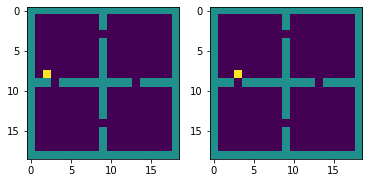

In [197]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(s[0])
axes[1].imshow(ns[0])

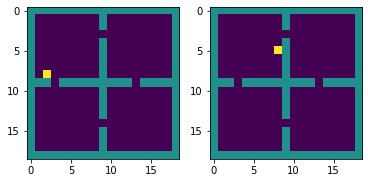

In [198]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(s[0])
axes[1].imshow(plan[0][0])